In [1]:
# This file is to implement the designed feature-based similarity distance method
# The cost function is defined as the square of discrepancy between DTW of two real time series and Euclidean of the
# two time series in new feature space.
# Date: 9/21/2016
# Author: Zexi Chen(zchen22)

In [56]:
import numpy
import six.moves.cPickle as pickle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# samples1 file contains 10000 time series, and each one has 23 time points
# It is used as the training data
fileObject1 = open('../theano/data/samples1','r')
train_set = pickle.load(fileObject1)

In [4]:
# sample2 file contains 10000 time series, same format
# It is used as the validation set
fileObject2 = open('../theano/data/samples2','r')
valid_set = pickle.load(fileObject2)

In [5]:
# sample3 file contains 10000 time series served as test data
fileObject3 = open('../theano/data/samples3','r')
test_set = pickle.load(fileObject3)

In [6]:
# visualize the training data
train_set[:4]

array([[ 37,  26,  33,  54,  39, 102, 112, 130, 171, 128, 125, 195, 196,
        226, 225, 221, 184, 162, 143, 114, 103, 111, 111],
       [ 96,  92,  98,  42,  99,  96, 114, 157, 152, 125, 149, 209, 237,
        236, 237, 228, 171, 151, 126, 116, 108,  47, 107],
       [ 36,  36,  29,  55,  42,  85,  94, 107, 109, 110, 111, 159, 229,
        237, 240, 241, 133, 121, 104,  94,  96,  93,  87],
       [ 32,  91,  88,  93,  92,  98,  95, 100, 110, 149, 196, 220, 231,
        231, 231, 218, 156, 108,  92,  88,  91,  91,  89]])

In [7]:
# reshape the array, concatenate two time series as one training instance
train_set1 = numpy.reshape(train_set, (train_set.shape[0]/2, train_set.shape[1]*2))
valid_set1 = numpy.reshape(valid_set, (valid_set.shape[0]/2, valid_set.shape[1]*2))
test_set1 = numpy.reshape(test_set, (test_set.shape[0]/2, test_set.shape[1]*2))

In [8]:
# visualize the reshaped train data. Every two consecutive rows are concatenated into one row with 46 dimension
train_set1[:2]

array([[ 37,  26,  33,  54,  39, 102, 112, 130, 171, 128, 125, 195, 196,
        226, 225, 221, 184, 162, 143, 114, 103, 111, 111,  96,  92,  98,
         42,  99,  96, 114, 157, 152, 125, 149, 209, 237, 236, 237, 228,
        171, 151, 126, 116, 108,  47, 107],
       [ 36,  36,  29,  55,  42,  85,  94, 107, 109, 110, 111, 159, 229,
        237, 240, 241, 133, 121, 104,  94,  96,  93,  87,  32,  91,  88,
         93,  92,  98,  95, 100, 110, 149, 196, 220, 231, 231, 231, 218,
        156, 108,  92,  88,  91,  91,  89]])

In [9]:
# define dtw function
def dtw(list1, list2, window = 1):
    len1 = len(list1)
    len2 = len(list2)
    mat = [[float('inf') for x in range(len2 + 1)] for y in range(len1 + 1)]
    mat[0][0] = 0
    for i in range(1,len1 + 1):
        if i - window <= 1:
            start = 1
        else:
            start = i - window
        
        if i + window <= len2:
            end = i + window
        else:
            end = len2
        for j in range(start, end + 1):
            cost = abs(float(list1[i - 1] - list2[j - 1]))
            mat[i][j] = cost + min(mat[i-1][j], mat[i][j-1],mat[i-1][j-1])
        
    return mat[len1][len2]

In [10]:
# define euclidean distance function 
def euclideanDist(list1,list2):
    distance = 0
    for x in range(len(list1)):
        distance += pow((list1[x]-list2[x]),2)
    return math.sqrt(distance)

In [11]:
# calculate the dtw distance between the two time series in each row of the training data validation data and test data 
# the dtw is used in the cost function as the target value to minimize
train_dtws = numpy.zeros((train_set1.shape[0],1))
for i in range(train_set1.shape[0]):
    train_dtws[i,0] = dtw(train_set1[i,0:23], train_set1[i,23:])
    
valid_dtws = numpy.zeros((valid_set1.shape[0],1))
for i in range(valid_set1.shape[0]):
    valid_dtws[i,0] = dtw(valid_set1[i,0:23], valid_set1[i,23:])
    
test_dtws = numpy.zeros((test_set1.shape[0],1))
for i in range(test_set1.shape[0]):
    test_dtws[i,0] = dtw(test_set1[i,0:23], test_set1[i,23:])

In [12]:
# build the neural network model
# start the tensorflow interaction interface
sess = tf.InteractiveSession()

In [13]:
# set the number of nerons in hidden layers
numFeatureMaps = 10

In [14]:
# generate the flow graph. 
# create two variable placehold, x for the training features, 
# y for the labels(in this model it is the dtw distance between two time series)
x = tf.placeholder(tf.float32, shape=[None, train_set1.shape[1]])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

In [15]:
# define the weight matrix, initialize randomly 
# truncated_normal: output random values from a truncated normal distribution with value out of 2 sd dropped 
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

In [16]:
# define the bias
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [17]:
# reshape the training input to comform the CNN model [batch size, width, height, color channels]
# x_ts = tf.to_float(x_ts)
x_ts = tf.reshape(x, [-1,46,1,1])

In [18]:
# initialize the weight matrix and the bias
# specify the filter size: [filter_width, filter_height, in_channels, out_channels]
W_conv1 = weight_variable([23,1,1,numFeatureMaps])
b_conv1 = bias_variable([numFeatureMaps])

In [19]:
# specify the model we use and set up the paratemers
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,23,1,1], padding='SAME')

In [20]:
# the non-linear function to transfer input to hidden layer
h_conv1 = tf.nn.relu(conv2d(x_ts, W_conv1) + b_conv1)

In [21]:
# define the cost function: (dtw-euclidean(timeseries1 new features, timeseries2 new features))^2
h_conv1_flat = tf.reshape(h_conv1,[-1, 2 * numFeatureMaps])
h_conv1_flat_diff = tf.square(tf.sub(h_conv1_flat[:,:numFeatureMaps],h_conv1_flat[:,numFeatureMaps:]))
cost_function = tf.square(tf.sub(y_ ,tf.sqrt(tf.reduce_sum(h_conv1_flat_diff))))

In [22]:
# specify the training optimizer for the model
train_step = tf.train.AdagradOptimizer(1e-3).minimize(cost_function)

In [23]:
# initialize the model graph parameters
sess.run(tf.initialize_all_variables())

In [26]:
# run the model
train_error = []
valid_error = []
training_epochs = 10000
best_valid_error = numpy.inf
for i in range(training_epochs):
    train_step.run(feed_dict={x:train_set1, y_:train_dtws})
    if i%100 == 0:
        train_err = cost_function.eval(feed_dict={x:train_set1, y_:train_dtws})
        train_error.append(train_err.mean())
        valid_err = cost_function.eval(feed_dict={x:valid_set1, y_:valid_dtws})
        valid_error.append(valid_err.mean())
        print("step %d, the mean error of the training data %g, vilidation data %g"%(i, train_error[-1], valid_error[-1]))
        #print h_conv1_flat.eval(feed_dict={x:test_set1})
        if valid_error[-1] < best_valid_error * 0.995:
            best_valid_error = valid_error[-1]
            
            saver = tf.train.Saver({"W_0": W_conv1, "b_0":b_conv1})

step 0, the mean error of the training data 3.90132e+06, vilidation data 4.00409e+06
step 100, the mean error of the training data 1.10257e+06, vilidation data 1.13014e+06
step 200, the mean error of the training data 815006, vilidation data 838264
step 300, the mean error of the training data 654765, vilidation data 674945
step 400, the mean error of the training data 543838, vilidation data 561621
step 500, the mean error of the training data 461018, vilidation data 476806
step 600, the mean error of the training data 396463, vilidation data 410696
step 700, the mean error of the training data 344716, vilidation data 357721
step 800, the mean error of the training data 302393, vilidation data 314275
step 900, the mean error of the training data 267279, vilidation data 278180
step 1000, the mean error of the training data 237824, vilidation data 247903
step 1100, the mean error of the training data 212884, vilidation data 222243
step 1200, the mean error of the training data 191591, v

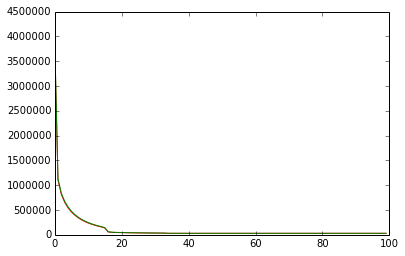

In [57]:
Xaxis = range(training_epochs/100)
plt.plot(Xaxis, train_error, 'r',label='train error')
plt.plot(Xaxis, valid_error, 'g',label='validation error')
plt.show()

In [37]:
with tf.Session() as sess:
  sess.run(tf.initialize_all_variables())
  save_path = saver.save(sess, "model_param/model.ckpt")
  print("Model saved in file: %s" % save_path)

Model saved in file: model_param/model.ckpt


In [50]:
W_0 = tf.Variable(-1.0, validate_shape=False, name='W_0')
b_0 = tf.Variable(-1.0, validate_shape=False, name='b_0')
with tf.Session() as session:
    saver = tf.train.Saver()
    saver.restore(session, "model_param/model.ckpt")
    print(session.run(tf.all_variables()))

In [54]:
# redo the method with re-scaled input data, and the input value ranges [0,1]
train_set2 = train_set1/255.0
valid_set2 = valid_set1/255.0
test_set2 = test_set1/255.0

In [55]:
train_set2

array([[ 0.14509804,  0.10196078,  0.12941176, ...,  0.42352941,
         0.18431373,  0.41960784],
       [ 0.14117647,  0.14117647,  0.11372549, ...,  0.35686275,
         0.35686275,  0.34901961],
       [ 0.87843137,  0.22352941,  0.91764706, ...,  0.24313725,
         0.95294118,  0.38431373],
       ..., 
       [ 0.1254902 ,  0.14117647,  0.1372549 , ...,  0.38823529,
         0.34901961,  0.34509804],
       [ 0.19607843,  0.16470588,  0.16862745, ...,  0.36862745,
         0.36470588,  0.18039216],
       [ 0.28235294,  0.17647059,  0.17254902, ...,  0.34509804,
         0.35294118,  0.31764706]])

In [58]:
# calculate the dtw distance between the two time series in each row of the training data validation data and test data 
# the dtw is used in the cost function as the target value to minimize
train_dtws2 = numpy.zeros((train_set2.shape[0],1))
for i in range(train_set2.shape[0]):
    train_dtws2[i,0] = dtw(train_set2[i,0:23], train_set2[i,23:])
    
valid_dtws2 = numpy.zeros((valid_set2.shape[0],1))
for i in range(valid_set2.shape[0]):
    valid_dtws2[i,0] = dtw(valid_set2[i,0:23], valid_set2[i,23:])
    
test_dtws2 = numpy.zeros((test_set2.shape[0],1))
for i in range(test_set2.shape[0]):
    test_dtws2[i,0] = dtw(test_set2[i,0:23], test_set2[i,23:])

In [ ]:
# the non-linear function to transfer input to hidden layer
h_conv1 = tf.nn.sigmoid(conv2d(x_ts, W_conv1) + b_conv1)